In [1]:
from coddiwomple.openmm.integrators import OMMLI
from coddiwomple.openmm.propagators import OMMBIP
from coddiwomple.openmm.reporters import OpenMMReporter
from openmmtools.states import ThermodynamicState, SamplerState
from simtk import unit
from copy import deepcopy
import os
import sys
import numpy as np
import pickle
import tqdm
import mdtraj.utils as mdtrajutils
import mdtraj as md
import torch
import torchani
from openmmtools.constants import kB

from openmmtools import cache, utils
from perses.dispersed.utils import check_platform, configure_platform
cache.global_context_cache.platform = configure_platform(utils.get_fastest_platform().getName())
atomic_num_to_symbol_dict = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}
mass_dict_in_daltons = {'H': 1.0, 'C': 12.0, 'N': 14.0, 'O': 16.0}

import logging
from copy import deepcopy

#####Instantiate Logger#####
logging.basicConfig(level = logging.NOTSET)
_logger = logging.getLogger("hybrid_propagators")
_logger.setLevel(logging.DEBUG)


RDKit WARNING: [23:00:30] Enabling RDKit 2019.09.3 jupyter extensions


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CPU


In [2]:
class ANI1_force_and_energy(object):
    # some class attributes
    mass_unit = unit.dalton
    distance_unit = unit.nanometers
    time_unit = unit.femtoseconds
    energy_unit = unit.kilojoules_per_mole
    ani_distance_unit = unit.angstroms
    hartree_to_kJ_per_mole = 2625.499638
    ani_energy_unit = hartree_to_kJ_per_mole * energy_unit
    nm_to_angstroms = 10.
    angstroms_to_nm = 1e-1

    def __init__(self,
                 model,
                 atoms,
                 platform='cpu',
                 temperature=300 * unit.kelvin
                 ):

        """
        Performs energy and force calculations.
        Slightly modified code from:
            https://gist.github.com/wiederm/7ac5c29e5a0dea9d17ef16dda93fe02d#file-reweighting-py-L42; thanks, Marcus

        Parameters
        ----------
        model: torchani.models object
            model from which to compute energies and forces
        atoms: str
            a string of atoms in the indexed order
        platform : str, default 'cpu',
            platform on which to initialize the model device
        temperature : float * unit.kelvin, default 300 * unit.kelvin
            temperature
        """
        self.model = model
        self.atoms = atoms

        self.platform = platform
        self.device = torch.device(self.platform)
        if self.platform == 'cpu':
            torch.set_num_threads(2)
        else:
            raise Exception(f"we don't support gpu just yet")

        self.species = self.model.species_to_tensor(atoms).to(self.device).unsqueeze(0)
        self.temperature = temperature
        self.beta = 1.0 / (kB * temperature)

        self.W_shads = []
        self.W = []

    def minimize(self,
                 coords: unit.quantity.Quantity,
                 maxiter: int = 1000):
        """
        Minimizes the molecule. Note, we usually don't want to do this given an input structure since they are already distributed i.i.d.

        Parameters
        ----------
        coords:simtk.unit.quantity.Quantity
        maxiter: int
            Maximum number of minimization steps performed.

        Returns
        -------
        coords:simtk.unit.quantity.Quantity
        """

        assert (type(coords) == unit.quantity.Quantity)

        x = coords.value_in_unit(unit.angstrom)
        self.memory_of_energy = []
        print("Begin minimizing...")
        f = optimize.minimize(self._target_energy_function, x, method='BFGS',
                              jac=True, options={'maxiter': maxiter, 'disp': True})

        _logger.critical(f"Minimization status: {f.success}")
        memory_of_energy = copy.deepcopy(self.memory_of_energy)
        self.memory_of_energy = []

        return f.x.reshape(-1, 3) * unit.angstrom, memory_of_energy

    def calculate_force(self,
                        x: unit.quantity.Quantity) -> (unit.quantity.Quantity, unit.quantity.Quantity):
        """
        Given a coordinate set the forces with respect to the coordinates are calculated.

        Parameters
        ----------
        x : array of floats, unit'd (distance unit)
            initial configuration

        Returns
        -------
        F : float, unit'd
        E : float, unit'd
        """
        #assert (type(x) == unit.quantity.Quantity)

        coordinates = torch.tensor([x.value_in_unit(unit.angstroms)],
                                   requires_grad=True, device=self.device, dtype=torch.float32)

        energy_in_hartree = self._calculate_energy(coordinates)

        # derivative of E (in kJ/mol) w.r.t. coordinates (in nm)
        derivative = torch.autograd.grad((energy_in_hartree).sum(), coordinates)[0]

        if self.platform == 'cpu':
            F = -1 * derivative[0].numpy()
        elif self.platform == 'cuda':
            F = - np.array(derivative.cpu())[0]
        else:
            raise RuntimeError('Platform needs to be specified. Either CPU or CUDA.')

        return (F * self.hartree_to_kJ_per_mole * (unit.kilojoule_per_mole / unit.angstrom),
                energy_in_hartree.item() * self.hartree_to_kJ_per_mole * unit.kilojoule_per_mole)

    def _calculate_energy(self, coordinates: torch.tensor):
        """
        Helpter function to return energies as tensor.
        Given a coordinate set the energy is calculated.

        Parameters
        ----------
        coordinates : torch.tensor
            coordinates in angstroms without units attached

        Returns
        -------
        energy_in_hartree : torch.tensor

        """

        # stddev_in_hartree = torch.tensor(0.0,device = self.device, dtype=torch.float64)
        energy_in_hartree = self.model((self.species, coordinates)).energies

        return energy_in_hartree

    def _target_energy_function(self, x) -> (float, np.array):
        """
        Given a coordinate set (x) the energy is calculated in kJ/mol.

        Parameters
        ----------
        x : array of floats, unit'd (distance unit)
            initial configuration

        Returns
        -------
        E : float, unitless (in kJ/mol)
        F_flat : (len(x) * 3, )-shaped np.array, unitless (in kJ/mol / unit.angstrom)
        """
        x = x.reshape(-1, 3) * unit.angstrom
        F, E = self.calculate_force(x)
        F_flat = -np.array(F.value_in_unit(unit.kilojoule_per_mole / unit.angstrom).flatten(), dtype=np.float64)
        self.memory_of_energy.append(E)
        return E.value_in_unit(unit.kilojoule_per_mole), F_flat

    def calculate_energy(self, x: unit.Quantity):
        """
        Given a coordinate set (x) the energy is calculated in kJ/mol.
        Parameters
        ----------
        x : array of floats, unit'd (angstroms)
            initial configuration

        Returns
        -------
        energy : unit.quantity.Quantity
            energy in kJ/mol
        """

        #assert (type(x) == unit.quantity.Quantity)
        coordinates = torch.tensor([x.value_in_unit(unit.angstroms)],
                                   requires_grad=True, device=self.device, dtype=torch.float32)

        energy_in_hartrees = self._calculate_energy(coordinates)
        energy = energy_in_hartrees.item() * self.hartree_to_kJ_per_mole * unit.kilojoule_per_mole
        return energy



In [45]:
class Integrator(OMMLI):
    def __init__(self,
                 temperature=300.0 * unit.kelvin,
                 collision_rate=1.0 / unit.picoseconds,
                 timestep=1.0 * unit.femtoseconds,
                 splitting="V R O R F",
                 constraint_tolerance=1e-6,
                 **kwargs):
        """Create a Langevin integrator with the prescribed operator splitting.

        arguments
            splitting : string, default: "V R O R"
                Sequence of "R", "V", "O" (and optionally "{", "}", "V0", "V1", ...) substeps to be executed each timestep.
                Forces are only used in V-step. Handle multiple force groups by appending the force group index
                to V-steps, e.g. "V0" will only use forces from force group 0. "V" will perform a step using all forces.
            temperature : np.unit.Quantity compatible with kelvin, default: 300.0*unit.kelvin
               Fictitious "bath" temperature
            collision_rate : np.unit.Quantity compatible with 1/picoseconds, default: 1.0/unit.picoseconds
               Collision rate
            timestep : np.unit.Quantity compatible with femtoseconds, default: 1.0*unit.femtoseconds
               Integration timestep
            constraint_tolerance : float, default: 1.0e-8
                Tolerance for constraint solver
        """
        #just super our previous method
        super().__init__(temperature,
                         collision_rate,
                         timestep,
                         splitting,
                         constraint_tolerance,
                         **kwargs)
        

    def _add_V_step(self, force_group="0"):
        """Deterministic velocity update, using only forces from force-group fg.

        arguments
            force_group : str, optional, default="0"
               Force group to use for this step
        """
        self.addComputeSum("old_ke", self._kinetic_energy)

        # update velocities
        if self._mts:
            self.addComputePerDof("v", "v + ((dt / {}) * moddi / m)".format(self._force_group_nV[force_group], force_group))
        else:
            self.addComputePerDof("v", "v + (dt / {}) * moddi / m".format(self._force_group_nV["0"]))

        self.addConstrainVelocities()


        self.addComputeSum("new_ke", self._kinetic_energy)
        self.addComputeGlobal("shadow_work", "shadow_work + (new_ke - old_ke)")
    
    def _add_F_step(self):
        """
        add an moddi update step
        """
        self.addComputePerDof('moddi', 'f')
        
    
    def _add_variables(self):
        super()._add_variables()
        self.addPerDofVariable('moddi', 0)
    
    def _add_integrator_steps(self):
        """
        Add the steps to the integrator--this can be overridden to place steps around the integration.
        """
        super()._add_integrator_steps()
        #self.addUpdateContextState()
    
    @property
    def _step_dispatch_table(self):
        dispatch_table = super()._step_dispatch_table
        dispatch_table['F'] = (self._add_F_step, False) #add a moddi variable
        return dispatch_table
        
    
class Propagator(OMMBIP):
    def __init__(self,
                 openmm_pdf_state,
                 openmm_pdf_state_subset,
                 subset_indices_map,
                 integrator,
                 ani_handler,
                 context_cache=None,
                 reassign_velocities=True,
                 n_restart_attempts=0,
                 reporter = None,
                 **kwargs):
        """
        arguments
            openmm_pdf_state : openmmtools.states.ThermodynamicState
                the pdf state of the propagator
            openmm_pdf_state_subset : openmmtools.states.ThermodynamicState
                the pdf state of the atom subset
            subset_indices_map : dict
                dict of {openmm_pdf_state atom_index : openmm_pdf_state_subset atom index}
            integrator : openmm.Integrator
                integrator of dynamics
            ani_handler : ANI1_force_and_energy
                handler for ani forces and potential energy
            context_cache : openmmtools.cache.ContextCache, optional
                The ContextCache to use for Context creation. If None, the global cache
                openmmtools.cache.global_context_cache is used (default is None).
            reassign_velocities : bool, optional
                If True, the velocities will be reassigned from the Maxwell-Boltzmann
                distribution at the beginning of the move (default is False).
            n_restart_attempts : int, optional
                When greater than 0, if after the integration there are NaNs in energies,
                the move will restart. When the integrator has a random component, this
                may help recovering. On the last attempt, the ``Context`` is
                re-initialized in a slower process, but better than the simulation
                crashing. An IntegratorMoveError is raised after the given number of
                attempts if there are still NaNs. 
            reporter : coddiwomple.openmm.reporter.OpenMMReporter, default None
                a reporter object to write trajectories
        """
        super().__init__(openmm_pdf_state,
                 integrator,
                 context_cache,
                 reassign_velocities,
                 n_restart_attempts)
        #create a pdf state for the subset indices (usually a vacuum system)
        self.pdf_state_subset = openmm_pdf_state_subset
        assert self.pdf_state_subset.temperature == self.pdf_state.temperature, f"the temperatures of the pdf states do not match"
        
        #create a dictionary for subset indices
        self._subset_indices_map = subset_indices_map
        
        #create an ani handler attribute that can be referenced
        self.ani_handler = ani_handler
        
        #create a context for the subset atoms that can be referenced
        self.context_subset, _ = cache.global_context_cache.get_context(self.pdf_state_subset)
        
        #create a reporter for the accumulated works
        self._state_works = {}
        self._state_works_counter = 0
        
        #create a reporter
        self._write_trajectory = False if reporter is None else True
        self.reporter=reporter
        if self._write_trajectory:
            from coddiwomple.particles import Particle
            self.particle = Particle(0)
        else:
            self.particle = None
        
    def _before_integration(self, *args, **kwargs):
        particle_state = args[0] #define the particle state
        n_iterations = args[1] #define the number of iterations
        
        self._current_state_works = [] #define an interim (auxiliary) list that will track the thermodynamic work of the current application
        self._current_state_works.append(0.0) #the first incremental work is always 0 since the importance function is identical to the first target distribution (i.e. fully interacting MM)
        
        self._iteration = 0.0 #define the first iteration as 0
        self._n_iterations = n_iterations #the number of iterations in the protocol is equal to the number of steps in the application
        
        #update the particle state and the particle state subset
        particle_state.update_from_context(self.context, ignore_velocities=True) #update the particle state from the context
        self.particle_state_subset = SamplerState(positions = particle_state.positions[list(self._subset_indices_map.keys())]) #create a particle state from the subset context
        self.particle_state_subset.apply_to_context(self.context_subset, ignore_velocities=True) #apply the subset particle state to its context
        self.particle_state_subset.update_from_context(self.context_subset, ignore_velocities=True) #update the subset particle state from its context to updated the potential energy
        #print(f"particle subset reduced potential: {self.pdf_state_subset.reduced_potential(self.particle_state_subset)}")
           
        #get the reduced potential
        reduced_potential = self._compute_hybrid_potential(_lambda = self._iteration / self._n_iterations, particle_state = particle_state)
        perturbed_reduced_potential = self._compute_hybrid_potential(_lambda = (self._iteration + 1.0) / self._n_iterations, particle_state = particle_state)
        self._current_state_works.append(self._current_state_works[-1] + (perturbed_reduced_potential - reduced_potential))
        #print(f"reduced_potential: {reduced_potential}; perturbed_potential: {perturbed_reduced_potential}")
        
        #make a new force object
        mm_force_matrix = self._compute_hybrid_forces(_lambda = (self._iteration + 1.0) / self._n_iterations, particle_state = particle_state).value_in_unit_system(unit.md_unit_system)
        self.integrator.setPerDofVariableByName('moddi', mm_force_matrix) 
        
        #report
        if self._write_trajectory:
            self.particle.update_state(particle_state)
            self.reporter.record([self.particle])
        
        #logger
        #self._log_context_parameters()
        
        
    
    def _during_integration(self, *args, **kwargs):
        particle_state = args[0]
        self._iteration += 1.0
        
        
        #update the particle state and the particle state subset
        particle_state.update_from_context(self.context, ignore_velocities=True) #update the particle state from the context
        self.particle_state_subset.positions = particle_state.positions[list(self._subset_indices_map.keys())] #update the particle subset positions appropriately
        self.particle_state_subset.apply_to_context(self.context_subset, ignore_velocities=True) #apply the subset particle state to its context
        self.particle_state_subset.update_from_context(self.context_subset, ignore_velocities=True) #update the subset particle state from its context to updated the potential energy
        
        #get the reduced potential
        if self._iteration < self._n_iterations:
            reduced_potential = self._compute_hybrid_potential(_lambda = self._iteration / self._n_iterations, particle_state = particle_state)
            perturbed_reduced_potential = self._compute_hybrid_potential(_lambda = (self._iteration + 1.0) / self._n_iterations, particle_state = particle_state)
            self._current_state_works.append(self._current_state_works[-1] + (perturbed_reduced_potential - reduced_potential))
            
            #and create a new modified force
            mm_force_matrix = self._compute_hybrid_forces(_lambda = (self._iteration + 1.0) / self._n_iterations, particle_state = particle_state).value_in_unit_system(unit.md_unit_system)
            self.integrator.setPerDofVariableByName('moddi', mm_force_matrix) 
        else:
            #we are done
            pass
        
        if self._write_trajectory:
            self.particle.update_state(particle_state)
            if self._iteration == self._n_iterations:
                self.reporter.record([self.particle], save_to_disk=True)
            else:
                self.reporter.record([self.particle], save_to_disk=False)
        
        #logger
        #self._log_context_parameters()
            
            
        
    def _after_integration(self, *args, **kwargs):
        self._state_works[self._state_works_counter] = deepcopy(self._current_state_works)
        self._state_works_counter += 1
        
        if self._write_trajectory:
            self.reporter.reset()
        #self._log_context_parameters()
        

    def _compute_hybrid_potential(self,_lambda, particle_state):
        """
        function to compute the hybrid reduced potential defined as follows:
        U(x_rec, x_lig) = u_mm,rec(x_rec) - lambda*u_mm,lig(x_lig) + lambda*u_ani,lig(x_lig)
        """
        reduced_potential = (self.pdf_state.reduced_potential(particle_state)
                             - _lambda * self.pdf_state_subset.reduced_potential(self.particle_state_subset)
                             + _lambda * self.ani_handler.calculate_energy(self.particle_state_subset.positions) * self.pdf_state.beta)
        return reduced_potential
    
    def _compute_hybrid_forces(self, _lambda, particle_state):
        """
        function to compute a hybrid force matrix of shape num_particles x 3
        in the spirit of the _compute_hybrid_potential, we compute the forces in the following way
            F(x_rec, x_lig) = F_mm(x_rec, x_lig) - lambda * F_mm(x_lig) + lambda * F_ani(x_lig)
        """
        # get the complex mm forces
        state = self.context.getState(getForces=True)
        mm_force_matrix = state.getForces(asNumpy=True)

        # get the ligand mm forces
        subset_state = self.context_subset.getState(getForces=True)
        mm_force_matrix_subset = subset_state.getForces(asNumpy=True)

        # get the ligand ani forces
        coords = self.particle_state_subset.positions
        subset_ani_force_matrix, energie = self.ani_handler.calculate_force(coords)

        # now combine the ligand forces
        subset_force_matrix = _lambda * (subset_ani_force_matrix - mm_force_matrix_subset)

        # and append to the complex forces...
        mm_force_matrix[list(self._subset_indices_map.keys()), :] += subset_force_matrix

        return mm_force_matrix

    def _get_context_subset_parameters(self):
        """
        return a dictionary of the self.context_subset's parameters

        returns
            context_parameters : dict
            {parameter name <str> : parameter value value <float>}
        """
        swig_parameters = self.context_subset.getParameters()
        context_parameters = {q: swig_parameters[q] for q in swig_parameters}
        return context_parameters
    
    def _log_context_parameters(self):
        """
        log the context and context subset parameters
        """
        context_parameters = self._get_context_parameters()
        context_subset_parameters = self._get_context_subset_parameters()
        _logger.debug(f"\tcontext_parameters during integration:")
        for key, val in context_parameters.items():
            _logger.debug(f"\t\t{key}: {val}")
        
        _logger.debug(f"\tcontext subset parameters during integration:")
        for key, val in context_subset_parameters:
            _logger.debug(f"\t\t{key}: {val}")
        
    
    @property
    def state_works(self):
        return self._state_works      

In [57]:
def annealed_importance_sampling(system,
                                 system_subset,
                                 subset_indices_map,
                                 endstate_cache_filename,
                                 directory_name,
                                 trajectory_prefix,
                                 md_topology,
                                 number_of_applications,
                                 steps_per_application,
                                 integrator_kwargs = {'temperature': 300.0 * unit.kelvin,
                                                      'collision_rate': 1.0 / unit.picoseconds,
                                                      'timestep': 1.0 * unit.femtoseconds,
                                                      'splitting': "V R O R F",
                                                      'constraint_tolerance': 1e-6,
                                                      'pressure': 1.0 * unit.atmosphere},
                                 save_indices = None,
                                 position_extractor = None
                                ):
    """
    conduct annealed importance sampling in the openmm regime

    arguments
        system : openmm.System
            system
        system_subset : openmm.System
            subset system
        subset_indices_map : dict
            dict of {openmm_pdf_state atom_index : openmm_pdf_state_subset atom index}
        endstate_cache_filename : str
            path to the endstate cache pdb
        directory_name : str
            directory that will be written to
        trajectory_prefix : str
            .pdb prefix
        md_topology : mdtraj.Topology
            topology that will write the trajectory
        save_indices : list
            list of indices that will be saved 
        number_of_applications : int
            number of applications of the propagator
        steps_per_application : int
            number of integration steps per application
        integrator_kwargs : dict, see default
            kwargs to pass to OMMLIAIS integrator
        save_indices : list(int)
            list of indices of md_topology atoms to save to disk
        position_extractor : function, default None
            function to extract appropriate positons from the cache
    """
    from coddiwomple.particles import Particle
    from coddiwomple.openmm.states import OpenMMParticleState, OpenMMPDFState
    #load the endstate cache
    traj = md.Trajectory.load(endstate_cache_filename)
    num_frames = traj.n_frames
    print(f"loaded {num_frames} from the cache")
    
    #make a handle object for ANI
    species_str = ''.join([atom.element.symbol for atom in md_topology.subset(list(subset_indices_map.keys())).atoms])
    print(f"species string: {species_str}")
    ani_handler = ANI1_force_and_energy(model = torchani.models.ANI1ccx(),
                                                 atoms=species_str,
                                                 platform='cpu',
                                                 temperature=integrator_kwargs['temperature'])

    #make thermostates
    pdf_state = ThermodynamicState(system = system, temperature = integrator_kwargs['temperature'], pressure= integrator_kwargs['pressure'])
    pdf_state_subset = ThermodynamicState(system = system_subset, temperature = integrator_kwargs['temperature'], pressure = None)
    
    #make a reporter
    reporter = OpenMMReporter(directory_name, trajectory_prefix, md_topology, subset_indices = save_indices)
    
    
    #make an integrator
    integrator = Integrator(**integrator_kwargs)
    
    #make a propagator
    propagator = Propagator(openmm_pdf_state = pdf_state,
                 openmm_pdf_state_subset = pdf_state_subset,
                 subset_indices_map = subset_indices_map,
                 integrator = integrator,
                 ani_handler = ani_handler,
                 context_cache=None,
                 reassign_velocities=True,
                 n_restart_attempts=0,
                 reporter = reporter)

    frames = np.random.choice(range(num_frames), number_of_applications)
    particle = Particle(0)
    
    for i in tqdm.trange(number_of_applications):
        if position_extractor is not None:
            positions = position_extractor(traj.xyz[frames[i]] * unit.nanometers)
        else:
            positions = traj.xyz[frames[i]] * unit.nanometers
        particle_state = OpenMMParticleState(positions = positions, box_vectors = traj.unitcell_vectors[frames[i]]*unit.nanometers)
        particle.update_state(particle_state)
        #try:
        _, _return_dict = propagator.apply(particle_state, n_steps = steps_per_application, reset_integrator=True, apply_pdf_to_context=True)
        #except Exception as e:
        #    print(e)


    return propagator.state_works

In [68]:
#Example calculation: let's do benzene --> methylbenzene
from pkg_resources import resource_filename
import pickle
import mdtraj as md
solvent_factory_filename = resource_filename('coddiwomple', f"/data/perses_data/benzene_methylbenzene.solvent.factory.pkl")
vacuum_factory_filename = resource_filename('coddiwomple', f"/data/perses_data/benzene_methylbenzene.vacuum.factory.pkl")

with open(solvent_factory_filename, 'rb') as f:
    solvent_factory = pickle.load(f)

with open(vacuum_factory_filename, 'rb') as f:
    vacuum_factory = pickle.load(f)


system = solvent_factory._topology_proposal._new_system
system_subset = vacuum_factory._topology_proposal._new_system
subset_indices_map = {i:j for i, j in zip(range(1119, 1134), range(15))} #map for one endstate 'anisole'
endstate_cache_filename = '/mnt/c/Users/domin/github/codditest/1_endstate_cache/benzene_methylbenzene.solvent.0000.pdb'
directory_name = 'methylbenzene_solvent'
trajectory_prefix = 'troubleshoot'
md_topology = md.Topology.from_openmm(solvent_factory._topology_proposal._new_topology)



In [69]:
list(solvent_factory._topology_proposal._new_topology.atoms())[-20:]

[<Atom 1114 (H1) of chain 1 residue 371 (HOH)>,
 <Atom 1115 (H2) of chain 1 residue 371 (HOH)>,
 <Atom 1116 (O) of chain 1 residue 372 (HOH)>,
 <Atom 1117 (H1) of chain 1 residue 372 (HOH)>,
 <Atom 1118 (H2) of chain 1 residue 372 (HOH)>,
 <Atom 1119 (C5) of chain 2 residue 373 (MOL)>,
 <Atom 1120 (C4) of chain 2 residue 373 (MOL)>,
 <Atom 1121 (C6) of chain 2 residue 373 (MOL)>,
 <Atom 1122 (C3) of chain 2 residue 373 (MOL)>,
 <Atom 1123 (C7) of chain 2 residue 373 (MOL)>,
 <Atom 1124 (C2) of chain 2 residue 373 (MOL)>,
 <Atom 1125 (C1) of chain 2 residue 373 (MOL)>,
 <Atom 1126 (H6) of chain 2 residue 373 (MOL)>,
 <Atom 1127 (H5) of chain 2 residue 373 (MOL)>,
 <Atom 1128 (H7) of chain 2 residue 373 (MOL)>,
 <Atom 1129 (H4) of chain 2 residue 373 (MOL)>,
 <Atom 1130 (H8) of chain 2 residue 373 (MOL)>,
 <Atom 1131 (H1) of chain 2 residue 373 (MOL)>,
 <Atom 1132 (H2) of chain 2 residue 373 (MOL)>,
 <Atom 1133 (H3) of chain 2 residue 373 (MOL)>]

In [70]:
list(vacuum_factory._topology_proposal._new_topology.atoms())

[<Atom 0 (C5) of chain 1 residue 0 (MOL)>,
 <Atom 1 (C4) of chain 1 residue 0 (MOL)>,
 <Atom 2 (C6) of chain 1 residue 0 (MOL)>,
 <Atom 3 (C3) of chain 1 residue 0 (MOL)>,
 <Atom 4 (C7) of chain 1 residue 0 (MOL)>,
 <Atom 5 (C2) of chain 1 residue 0 (MOL)>,
 <Atom 6 (C1) of chain 1 residue 0 (MOL)>,
 <Atom 7 (H6) of chain 1 residue 0 (MOL)>,
 <Atom 8 (H5) of chain 1 residue 0 (MOL)>,
 <Atom 9 (H7) of chain 1 residue 0 (MOL)>,
 <Atom 10 (H4) of chain 1 residue 0 (MOL)>,
 <Atom 11 (H8) of chain 1 residue 0 (MOL)>,
 <Atom 12 (H1) of chain 1 residue 0 (MOL)>,
 <Atom 13 (H2) of chain 1 residue 0 (MOL)>,
 <Atom 14 (H3) of chain 1 residue 0 (MOL)>]

In [71]:
instantaneous_works = annealed_importance_sampling(system = system,
                                 system_subset = system_subset,
                                 subset_indices_map = subset_indices_map,
                                 endstate_cache_filename = endstate_cache_filename,
                                 directory_name = directory_name,
                                 trajectory_prefix = trajectory_prefix,
                                 md_topology = md_topology,
                                 number_of_applications = 50,
                                 steps_per_application = 1,
                                 integrator_kwargs = {'temperature': 300.0 * unit.kelvin,
                                                      'collision_rate': 1.0 / unit.picoseconds,
                                                      'timestep': 1.0 * unit.femtoseconds,
                                                      'splitting': "V R O R F",
                                                      'constraint_tolerance': 1e-6,
                                                      'pressure': 1.0 * unit.atmosphere},
                                 save_indices = None,
                                 position_extractor = solvent_factory.new_positions
                                )

loaded 87 from the cache
species string: CCCCCCCHHHHHHHH


DEBUG:openmm_reporters:creating trajectory storage object...
DEBUG:openmm_propagators:initializing Integrator...
DEBUG:openmm_propagators:Integrator: metropolization is False
DEBUG:openmm_propagators:Integrator: successfully parsed splitting string
DEBUG:openmm_propagators:Integrator: adding global variables...
DEBUG:openmm_propagators:Integrator: adding integrator steps...
DEBUG:openmm_propagators:Integrator: adding substep functions...
DEBUG:openmm_propagators:successfully executed ABCMeta init.
DEBUG:openmm_propagators:successfully equipped integrator: Integrator
DEBUG:openmm_propagators:integrator printable: None


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:06,  8.03it/s]

step      0 : allow forces to update the context state
step      1 : if(has_kT_changed = 1):
step      2 :    sigma <- sqrt(kT/m)
step      3 :    has_kT_changed <- 0
step      4 : end
step      5 : old_ke <- sum(0.5 * m * v * v)
step      6 : v <- v + (dt / 1) * moddi / m
step      7 : constrain velocities
step      8 : new_ke <- sum(0.5 * m * v * v)
step      9 : shadow_work <- shadow_work + (new_ke - old_ke)
step     10 : old_pe <- energy
step     11 : old_ke <- sum(0.5 * m * v * v)
step     12 : x <- x + ((dt / 2) * v)
step     13 : x1 <- x
step     14 : constrain positions
step     15 : v <- v + ((x - x1) / (dt / 2))
step     16 : constrain velocities
step     17 : new_pe <- energy
step     18 : new_ke <- sum(0.5 * m * v * v)
step     19 : shadow_work <- shadow_work + (new_ke + new_pe) - (old_ke + old_pe)
step     20 : old_ke <- sum(0.5 * m * v * v)
step     21 : v <- (a * v) + (b * sigma * gaussian)
step     22 : constrain velocities
step     23 : new_ke <- sum(0.5 * m * v * v)
s



  4%|▍         | 2/50 [00:00<00:05,  8.06it/s]

  6%|▌         | 3/50 [00:00<00:05,  7.93it/s]

  8%|▊         | 4/50 [00:00<00:05,  8.12it/s]

 10%|█         | 5/50 [00:00<00:05,  8.19it/s]

 12%|█▏        | 6/50 [00:00<00:05,  8.06it/s]

 14%|█▍        | 7/50 [00:00<00:05,  8.15it/s]

 16%|█▌        | 8/50 [00:00<00:05,  8.20it/s]

 18%|█▊        | 9/50 [00:01<00:04,  8.27it/s]

 20%|██        | 10/50 [00:01<00:04,  8.20it/s]

 22%|██▏       | 11/50 [00:01<00:04,  8.38it/s]

 24%|██▍       | 12/50 [00:01<00:04,  8.46it/s]

 26%|██▌       | 13/50 [00:01<00:04,  8.24it/s]

 28%|██▊       | 14/50 [00:01<00:04,  8.31it/s]

 30%|███       | 15/50 [00:01<00:04,  8.46it/s]

 32%|███▏      | 16/50 [00:01<00:04,  8.49it/s]

 34%|███▍      | 17/50 [00:02<00:03,  8.41it/s]

 36%|███▌      | 18/50 [00:02<00:03,  8.41it/s]

 38%|███▊      | 19/50 [00:02<00:03,  7.93it/s]

 40%|████      | 20/50 [00:02<00:03,  8.07it/s]

 42%|████▏     | 21/50 [00:02<00:03,  8.26it/s]

 44%|████▍     | 22/50 [00

In [73]:
zehn_iteration_works = annealed_importance_sampling(system = system,
                                 system_subset = system_subset,
                                 subset_indices_map = subset_indices_map,
                                 endstate_cache_filename = endstate_cache_filename,
                                 directory_name = directory_name,
                                 trajectory_prefix = trajectory_prefix,
                                 md_topology = md_topology,
                                 number_of_applications = 50,
                                 steps_per_application = 10,
                                 integrator_kwargs = {'temperature': 300.0 * unit.kelvin,
                                                      'collision_rate': 1.0 / unit.picoseconds,
                                                      'timestep': 1.0 * unit.femtoseconds,
                                                      'splitting': "V R O R F",
                                                      'constraint_tolerance': 1e-6,
                                                      'pressure': 1.0 * unit.atmosphere},
                                 save_indices = None,
                                 position_extractor = solvent_factory.new_positions
                                )

loaded 87 from the cache
species string: CCCCCCCHHHHHHHH


DEBUG:openmm_reporters:creating trajectory storage object...
DEBUG:openmm_propagators:initializing Integrator...
DEBUG:openmm_propagators:Integrator: metropolization is False
DEBUG:openmm_propagators:Integrator: successfully parsed splitting string
DEBUG:openmm_propagators:Integrator: adding global variables...
DEBUG:openmm_propagators:Integrator: adding integrator steps...
DEBUG:openmm_propagators:Integrator: adding substep functions...
DEBUG:openmm_propagators:successfully executed ABCMeta init.
DEBUG:openmm_propagators:successfully equipped integrator: Integrator
DEBUG:openmm_propagators:integrator printable: None


  0%|          | 0/50 [00:00<?, ?it/s]

step      0 : allow forces to update the context state
step      1 : if(has_kT_changed = 1):
step      2 :    sigma <- sqrt(kT/m)
step      3 :    has_kT_changed <- 0
step      4 : end
step      5 : old_ke <- sum(0.5 * m * v * v)
step      6 : v <- v + (dt / 1) * moddi / m
step      7 : constrain velocities
step      8 : new_ke <- sum(0.5 * m * v * v)
step      9 : shadow_work <- shadow_work + (new_ke - old_ke)
step     10 : old_pe <- energy
step     11 : old_ke <- sum(0.5 * m * v * v)
step     12 : x <- x + ((dt / 2) * v)
step     13 : x1 <- x
step     14 : constrain positions
step     15 : v <- v + ((x - x1) / (dt / 2))
step     16 : constrain velocities
step     17 : new_pe <- energy
step     18 : new_ke <- sum(0.5 * m * v * v)
step     19 : shadow_work <- shadow_work + (new_ke + new_pe) - (old_ke + old_pe)
step     20 : old_ke <- sum(0.5 * m * v * v)
step     21 : v <- (a * v) + (b * sigma * gaussian)
step     22 : constrain velocities
step     23 : new_ke <- sum(0.5 * m * v * v)
s



  2%|▏         | 1/50 [00:00<00:33,  1.47it/s]

  4%|▍         | 2/50 [00:01<00:32,  1.50it/s]

  6%|▌         | 3/50 [00:01<00:30,  1.52it/s]

  8%|▊         | 4/50 [00:02<00:29,  1.54it/s]

 10%|█         | 5/50 [00:03<00:28,  1.55it/s]

 12%|█▏        | 6/50 [00:03<00:28,  1.55it/s]

 14%|█▍        | 7/50 [00:04<00:27,  1.55it/s]

 16%|█▌        | 8/50 [00:05<00:26,  1.56it/s]

 18%|█▊        | 9/50 [00:05<00:26,  1.55it/s]

 20%|██        | 10/50 [00:06<00:26,  1.54it/s]

 22%|██▏       | 11/50 [00:07<00:25,  1.53it/s]

 24%|██▍       | 12/50 [00:07<00:24,  1.54it/s]

 26%|██▌       | 13/50 [00:08<00:24,  1.54it/s]

 28%|██▊       | 14/50 [00:09<00:23,  1.54it/s]

 30%|███       | 15/50 [00:09<00:23,  1.51it/s]

 32%|███▏      | 16/50 [00:10<00:23,  1.44it/s]

 34%|███▍      | 17/50 [00:11<00:22,  1.45it/s]

 36%|███▌      | 18/50 [00:11<00:22,  1.45it/s]

 38%|███▊      | 19/50 [00:12<00:21,  1.45it/s]

 40%|████      | 20/50 [00:13<00:20,  1.46it/s]

 42%|████▏     | 21/50 [00:

In [82]:
funfzig_iteration_works = annealed_importance_sampling(system = system,
                                 system_subset = system_subset,
                                 subset_indices_map = subset_indices_map,
                                 endstate_cache_filename = endstate_cache_filename,
                                 directory_name = directory_name,
                                 trajectory_prefix = trajectory_prefix,
                                 md_topology = md_topology,
                                 number_of_applications = 50,
                                 steps_per_application = 50,
                                 integrator_kwargs = {'temperature': 300.0 * unit.kelvin,
                                                      'collision_rate': 1.0 / unit.picoseconds,
                                                      'timestep': 1.0 * unit.femtoseconds,
                                                      'splitting': "V R O R F",
                                                      'constraint_tolerance': 1e-6,
                                                      'pressure': 1.0 * unit.atmosphere},
                                 save_indices = None,
                                 position_extractor = solvent_factory.new_positions
                                )

loaded 87 from the cache
species string: CCCCCCCHHHHHHHH


DEBUG:openmm_reporters:creating trajectory storage object...
DEBUG:openmm_propagators:initializing Integrator...
DEBUG:openmm_propagators:Integrator: metropolization is False
DEBUG:openmm_propagators:Integrator: successfully parsed splitting string
DEBUG:openmm_propagators:Integrator: adding global variables...
DEBUG:openmm_propagators:Integrator: adding integrator steps...
DEBUG:openmm_propagators:Integrator: adding substep functions...
DEBUG:openmm_propagators:successfully executed ABCMeta init.
DEBUG:openmm_propagators:successfully equipped integrator: Integrator
DEBUG:openmm_propagators:integrator printable: None


  0%|          | 0/50 [00:00<?, ?it/s]

step      0 : allow forces to update the context state
step      1 : if(has_kT_changed = 1):
step      2 :    sigma <- sqrt(kT/m)
step      3 :    has_kT_changed <- 0
step      4 : end
step      5 : old_ke <- sum(0.5 * m * v * v)
step      6 : v <- v + (dt / 1) * moddi / m
step      7 : constrain velocities
step      8 : new_ke <- sum(0.5 * m * v * v)
step      9 : shadow_work <- shadow_work + (new_ke - old_ke)
step     10 : old_pe <- energy
step     11 : old_ke <- sum(0.5 * m * v * v)
step     12 : x <- x + ((dt / 2) * v)
step     13 : x1 <- x
step     14 : constrain positions
step     15 : v <- v + ((x - x1) / (dt / 2))
step     16 : constrain velocities
step     17 : new_pe <- energy
step     18 : new_ke <- sum(0.5 * m * v * v)
step     19 : shadow_work <- shadow_work + (new_ke + new_pe) - (old_ke + old_pe)
step     20 : old_ke <- sum(0.5 * m * v * v)
step     21 : v <- (a * v) + (b * sigma * gaussian)
step     22 : constrain velocities
step     23 : new_ke <- sum(0.5 * m * v * v)
s



  2%|▏         | 1/50 [00:03<02:38,  3.24s/it]

  4%|▍         | 2/50 [00:06<02:34,  3.21s/it]

  6%|▌         | 3/50 [00:09<02:27,  3.14s/it]

  8%|▊         | 4/50 [00:12<02:21,  3.09s/it]

 10%|█         | 5/50 [00:15<02:22,  3.16s/it]

 12%|█▏        | 6/50 [00:18<02:20,  3.19s/it]

 14%|█▍        | 7/50 [00:22<02:23,  3.33s/it]

 16%|█▌        | 8/50 [00:26<02:25,  3.47s/it]

 18%|█▊        | 9/50 [00:29<02:21,  3.44s/it]

 20%|██        | 10/50 [00:33<02:17,  3.44s/it]

 22%|██▏       | 11/50 [00:36<02:13,  3.41s/it]

 24%|██▍       | 12/50 [00:39<02:08,  3.38s/it]

 26%|██▌       | 13/50 [00:43<02:06,  3.43s/it]

 28%|██▊       | 14/50 [00:46<02:02,  3.41s/it]

 30%|███       | 15/50 [00:50<02:07,  3.64s/it]

 32%|███▏      | 16/50 [00:56<02:20,  4.14s/it]

 34%|███▍      | 17/50 [01:05<03:03,  5.56s/it]

 36%|███▌      | 18/50 [01:13<03:24,  6.38s/it]

 38%|███▊      | 19/50 [01:17<02:56,  5.70s/it]

 40%|████      | 20/50 [01:21<02:36,  5.21s/it]

 42%|████▏     | 21/50 [01:

In [76]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Text(0.5, 1.0, 'Energie Verteilung')

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal

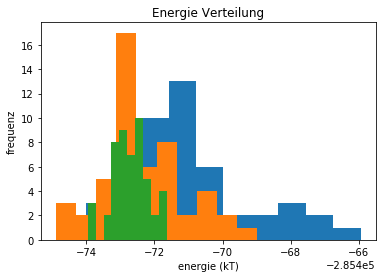

In [85]:
inst_works = [val[-1] for val in instantaneous_works.values()]
plt.hist(inst_works)

_zehn_works = [val[-1] for val in zehn_iteration_works.values()]
plt.hist(_zehn_works)

_funfzig_works = [val[-1] for val in funfzig_iteration_works.values()]
plt.hist(_funfzig_works)
plt.xlabel(f"energie (kT)")
plt.ylabel(f"frequenz")
plt.title(f"Energie Verteilung")